In [2]:
import numpy as np
from scipy.stats import dirichlet
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gamma

def an_post(index, hm, xt, alpha):
    w0x = np.arange(1e-6, 1, 1/hm)
    x = tqdm.tqdm( w0x)
    w0y = []
    for w0 in x:
        w1x = np.arange(1e-6, 1-w0, 1/hm)
        w1y = []
        for w1 in w1x:
            w2 = 1-w0-w1
            if index == 0: w1y.append( np.exp( log_posterior(xt, np.array([w0, w1, w2]), alpha  ) ) ) 
            elif index == 1: w1y.append( np.exp( log_posterior(xt, np.array([w1, w0, w2]), alpha  ) ) ) 
            else: w1y.append( np.exp( log_posterior(xt, np.array([w2, w1, w0]), alpha  ) ) ) 
        w0y.append( np.trapz( np.array(w1y), w1x) )
    y = np.array(w0y)
    return w0x, y/np.trapz(y, w0x)

def generate_xt(n_pars, hm):
    xt = []
    for _ in range(hm):
        temp = np.linspace(10,1,n_pars) * np.random.uniform(0,1,n_pars)
        xt.append(temp/np.sum(temp))
    return np.array(xt)

def loglikelihood(xt, omega):
    return np.sum( np.log( np.array( [ np.sum(xt[i]*omega) for i in range(len(xt)) ] ) ) )

def log_posterior(xt, omega, alpha):
    return loglikelihood(xt, omega) + dirichlet.logpdf(omega, alpha = alpha)

def sampling(n, xt, alpha, alpha_prop):
    accepted = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        omega_new = np.hstack( dirichlet.rvs(alpha = alpha_prop, size = 1) )
        if log_rnd[i] <= log_acceptance_diri(xt, alpha, alpha_prop, omega, omega_new):
            omega = omega_new
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def sampling2(n, xt, alpha, eps, each):
    accepted = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    x = np.ones(len(alpha)) * len(alpha)
    omega = x/np.sum(x)
    alp = 1/eps**2
    scale = x*eps**2
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        x_pr = gamma.rvs(alp, scale = scale)
        omega_pr = x_pr/np.sum(x_pr)
        if i % each == 0: print(x_pr)
        if log_rnd[i] <= log_acceptance(xt, alpha, x, x_pr, omega, omega_pr, alp, eps, scale):
            omega = omega_pr
            x = x_pr
            scale = x_pr*eps**2
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def log_acceptance_diri(xt, alpha, alpha_prop, omega, omega_pr):
    return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) - dirichlet.logpdf(omega_pr, alpha = alpha_prop) + dirichlet.logpdf(omega, alpha = alpha_prop)

def log_acceptance(xt, alpha, x, x_pr, omega, omega_pr, alp, eps, scale):
            scale_reverse = x_pr*eps**2
            return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) + log_jacobian(x_pr) - log_jacobian(x) + norm.logpdf(np.sum(x_pr), loc = 0, scale = 1) - norm.logpdf(np.sum(x), loc = 0, scale = 1) - np.sum( gamma.logpdf(x_pr, a = alp, scale=scale) ) + np.sum( gamma.logpdf(x, a = alp, scale=scale_reverse) )

def log_jacobian(x):
    return -(len(x)) * np.log(np.sum(x))



In [3]:
def w1_post(w1arr, alpha, xt):
    a1,a2,a3 = alpha
    x1,y1,z1 = xt[0]
    x2,y2,z2 = xt[1]
    x3,y3,z3 = xt[2]
    y = []
    for w1 in w1arr:
        y.append( ((1-w1)**(-1+a2+a3)*w1**(-1+a1)*(-a2*(1+a2)*(2+a2)*(-1+w1)**3*y1*y2*y3+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y2*y3*(x1-z1)+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y2*y3*z1+a2*(1+a2)*(2+a2)*(-1+w1)**3*y2*y3*z1+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y1*y3*(x2-z2)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*y3*(x1-z1)*(x2-z2)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y3*z1*(x2-z2)-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y3*z1*(x2-z2)+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y1*y3*z2+a2*(1+a2)*(2+a2)*(-1+w1)**3*y1*y3*z2-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y3*(x1-z1)*z2-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y3*(x1-z1)*z2-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*y3*z1*z2-2*a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y3*z1*z2-a2*(1+a2)*(2+a2)*(-1+w1)**3*y3*z1*z2+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y1*y2*(x3-z3)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*y2*(x1-z1)*(x3-z3)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y2*z1*(x3-z3)-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y2*z1*(x3-z3)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*y1*(x2-z2)*(x3-z3)+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1**3*(x1-z1)*(x2-z2)*(x3-z3)+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1**2*z1*(x2-z2)*(x3-z3)+a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*z1*(x2-z2)*(x3-z3)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y1*z2*(x3-z3)-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y1*z2*(x3-z3)+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1**2*(x1-z1)*z2*(x3-z3)+a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*(x1-z1)*z2*(x3-z3)+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1*z1*z2*(x3-z3)+2*a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*z1*z2*(x3-z3)+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*z1*z2*(x3-z3)+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y1*y2*z3+a2*(1+a2)*(2+a2)*(-1+w1)**3*y1*y2*z3-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y2*(x1-z1)*z3-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y2*(x1-z1)*z3-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*y2*z1*z3-2*a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y2*z1*z3-a2*(1+a2)*(2+a2)*(-1+w1)**3*y2*z1*z3-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y1*(x2-z2)*z3-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y1*(x2-z2)*z3+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1**2*(x1-z1)*(x2-z2)*z3+a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*(x1-z1)*(x2-z2)*z3+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1*z1*(x2-z2)*z3+2*a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*z1*(x2-z2)*z3+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*z1*(x2-z2)*z3-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*y1*z2*z3-2*a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y1*z2*z3-a2*(1+a2)*(2+a2)*(-1+w1)**3*y1*z2*z3+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1*(x1-z1)*z2*z3+2*a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*(x1-z1)*z2*z3+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*(x1-z1)*z2*z3+(a2+a3)*(1+a2+a3)*(2+a2+a3)*z1*z2*z3+3*a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*z1*z2*z3+3*a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*z1*z2*z3+a2*(1+a2)*(2+a2)*(-1+w1)**3*z1*z2*z3))/((a2+a3)*(1+a2+a3)*(2+a2+a3)) )
    y = np.array(y)
    return y/np.trapz(y,w1arr)

def w2_post(w2arr, alpha, xt):
    a1,a2,a3 = alpha
    x1,y1,z1 = xt[0]
    x2,y2,z2 = xt[1]
    x3,y3,z3 = xt[2]
    y = []
    for w2 in w2arr:
        y.append( ((1-w2)**(-1+a1+a3)*w2**(-1+a2)*(-a1*(1+a1)*(2+a1)*(-1+w2)**3*x1*x2*x3+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x2*x3*(y1-z1)+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x2*x3*z1+a1*(1+a1)*(2+a1)*(-1+w2)**3*x2*x3*z1+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x1*x3*(y2-z2)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*x3*(y1-z1)*(y2-z2)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x3*z1*(y2-z2)-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x3*z1*(y2-z2)+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x1*x3*z2+a1*(1+a1)*(2+a1)*(-1+w2)**3*x1*x3*z2-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x3*(y1-z1)*z2-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x3*(y1-z1)*z2-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*x3*z1*z2-2*a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x3*z1*z2-a1*(1+a1)*(2+a1)*(-1+w2)**3*x3*z1*z2+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x1*x2*(y3-z3)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*x2*(y1-z1)*(y3-z3)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x2*z1*(y3-z3)-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x2*z1*(y3-z3)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*x1*(y2-z2)*(y3-z3)+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2**3*(y1-z1)*(y2-z2)*(y3-z3)+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2**2*z1*(y2-z2)*(y3-z3)+a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*z1*(y2-z2)*(y3-z3)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x1*z2*(y3-z3)-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x1*z2*(y3-z3)+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2**2*(y1-z1)*z2*(y3-z3)+a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*(y1-z1)*z2*(y3-z3)+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2*z1*z2*(y3-z3)+2*a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*z1*z2*(y3-z3)+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*z1*z2*(y3-z3)+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x1*x2*z3+a1*(1+a1)*(2+a1)*(-1+w2)**3*x1*x2*z3-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x2*(y1-z1)*z3-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x2*(y1-z1)*z3-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*x2*z1*z3-2*a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x2*z1*z3-a1*(1+a1)*(2+a1)*(-1+w2)**3*x2*z1*z3-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x1*(y2-z2)*z3-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x1*(y2-z2)*z3+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2**2*(y1-z1)*(y2-z2)*z3+a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*(y1-z1)*(y2-z2)*z3+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2*z1*(y2-z2)*z3+2*a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*z1*(y2-z2)*z3+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*z1*(y2-z2)*z3-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*x1*z2*z3-2*a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x1*z2*z3-a1*(1+a1)*(2+a1)*(-1+w2)**3*x1*z2*z3+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2*(y1-z1)*z2*z3+2*a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*(y1-z1)*z2*z3+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*(y1-z1)*z2*z3+(a1+a3)*(1+a1+a3)*(2+a1+a3)*z1*z2*z3+3*a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*z1*z2*z3+3*a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*z1*z2*z3+a1*(1+a1)*(2+a1)*(-1+w2)**3*z1*z2*z3))/((a1+a3)*(1+a1+a3)*(2+a1+a3)) )
    y = np.array(y)
    return y/np.trapz(y,w2arr)

def w3_post(w3arr, alpha, xt):
    a1,a2,a3 = alpha
    x1,y1,z1 = xt[0]
    x2,y2,z2 = xt[1]
    x3,y3,z3 = xt[2]
    y = []
    for w3 in w3arr:
        y.append( -(((1-w3)**(-1+a1+a2)*w3**(-1+a3)*(a1**3*((-1+w3)*x1-w3*z1)*((-1+w3)*x2-w3*z2)*((-1+w3)*x3-w3*z3)+a2*(2+3*a2+a2**2)*((-1+w3)*y1-w3*z1)*((-1+w3)*y2-w3*z2)*((-1+w3)*y3-w3*z3)+a1**2*(-3*w3*z1*((-1+w3)*x2-w3*z2)*((-1+w3)*x3-w3*z3)+(-1+w3)*x1*(a2*(-1+w3)*x3*((-1+w3)*y2-w3*z2)+3*w3*z2*(x3-w3*x3+w3*z3)+(-1+w3)*x2*(3*(-1+w3)*x3+a2*(-1+w3)*y3-3*w3*z3-a2*w3*z3)+a2*w3*(y3*(z2-w3*z2)+(y2-w3*y2+2*w3*z2)*z3))+a2*((-1+w3)*x2*((-1+w3)*x3*((-1+w3)*y1-w3*z1)+w3*(y3*(z1-w3*z1)+(y1-w3*y1+2*w3*z1)*z3))-w3*((-1+w3)*x3*((-1+w3)*y2*z1+(-1+w3)*y1*z2-2*w3*z1*z2)+w3*(-((-1+w3)*y3*z1*z2)+y2*(z1-w3*z1)*z3+(y1-w3*y1+3*w3*z1)*z2*z3))))+a1*(-2*w3*z1*((-1+w3)*x2-w3*z2)*((-1+w3)*x3-w3*z3)+(-1+w3)*x1*(a2**2*((-1+w3)*y2-w3*z2)*((-1+w3)*y3-w3*z3)+2*w3*z2*(x3-w3*x3+w3*z3)+(-1+w3)*x2*(2*(-1+w3)*x3+a2*(-1+w3)*y3-2*w3*z3-a2*w3*z3)+a2*((-1+w3)*x3*((-1+w3)*y2-w3*z2)+(-1+w3)*y2*((-1+w3)*y3-2*w3*z3)+w3*z2*(-2*(-1+w3)*y3+3*w3*z3)))+a2*((-1+w3)*x3*((-1+w3)*y1*((-1+w3)*y2-2*w3*z2)+w3*z1*(-2*(-1+w3)*y2+3*w3*z2))+(-1+w3)*x2*((-1+w3)*x3*((-1+w3)*y1-w3*z1)+(-1+w3)*y1*((-1+w3)*y3-2*w3*z3)+w3*z1*(-2*(-1+w3)*y3+3*w3*z3))-w3*((-1+w3)*y2*((-1+w3)*y3*z1+(-1+w3)*y1*z3-3*w3*z1*z3)+z2*((-1+w3)*y1*((-1+w3)*y3-3*w3*z3)+3*w3*z1*(y3-w3*y3+2*w3*z3))))+a2**2*((-1+w3)*x3*((-1+w3)*y1-w3*z1)*((-1+w3)*y2-w3*z2)+(-1+w3)*x2*((-1+w3)*y1-w3*z1)*((-1+w3)*y3-w3*z3)-w3*((-1+w3)*y2*((-1+w3)*y3*z1+(-1+w3)*y1*z3-2*w3*z1*z3)+z2*((-1+w3)*y1*((-1+w3)*y3-2*w3*z3)+w3*z1*(-2*(-1+w3)*y3+3*w3*z3)))))))/((a1+a2)*(1+a1+a2)*(2+a1+a2))) )
    y = np.array(y)
    return y/np.trapz(y,w3arr)

In [4]:
n_pars = 3
hm = 3
xt = generate_xt(n_pars, hm)
print(xt)

[[0.66281928 0.23321127 0.10396944]
 [0.27992351 0.67511852 0.04495796]
 [0.68290866 0.29284332 0.02424802]]


In [5]:
a = 0.5
alpha = np.ones(n_pars)*a
alpha_prop = np.ones(n_pars)

n = int(1e5)

samples = sampling(n, xt, alpha, alpha_prop)
eps = 1
each = int(1e4)
#samples2 = sampling2(n, xt, alpha, eps, each)

Acceptance rate 0.355682:   5%|▍         | 4937/100000 [00:02<00:54, 1747.56it/s]


KeyboardInterrupt: 

In [ ]:
anal_x = []
anal = []
for i in range(n_pars):
    x,y = an_post(i, 100, xt, alpha)
    anal_x.append(x)
    anal.append(y)


100%|██████████| 100/100 [00:00<00:00, 604.21it/s]


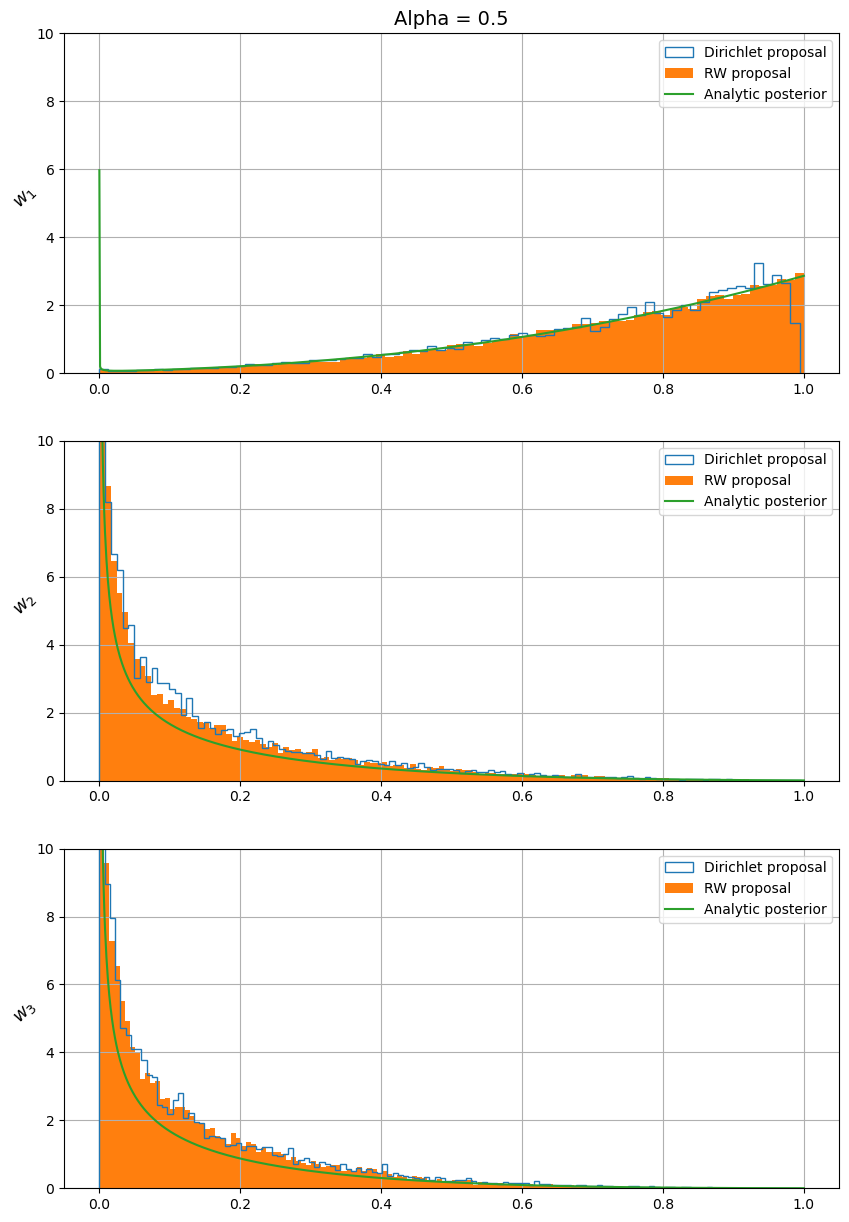

In [ ]:
fig, axs = plt.subplots( n_pars, figsize = [10,15] )
w = samples
w2 = samples2
x = np.arange(0, len(w[0]))
for i in range(n_pars):
    axs[i].hist(np.transpose(w)[i], bins = 'auto', histtype='step', density = True, label = 'Dirichlet proposal')
    axs[i].hist(np.transpose(w2)[i], bins = 'auto', density = True, label = 'RW proposal')
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    #axs[i].plot(anal_x[i], anal[i], label = 'Numerical posterior')
    if i == 0 : 
        xx = np.linspace(1e-6,1,1000)
        axs[i].plot(xx, w1_post(xx, alpha, xt), label = 'Analytic posterior')
    if i == 1 : 
        xx = np.linspace(1e-6,1,1000)
        axs[i].plot(xx, w2_post(xx, alpha, xt), label = 'Analytic posterior')
    if i == 2 : 
        xx = np.linspace(1e-6,1,1000)
        axs[i].plot(xx, w3_post(xx, alpha, xt), label = 'Analytic posterior')
    axs[i].grid()
    axs[i].legend()
    axs[i].set_ylim([0,10])
axs[0].set_title(f'Alpha = {alpha[0]}', size = 14)
plt.savefig('Alpha'+str(alpha[0])+'_second.png')
plt.show()
plt.close()

Acceptance rate 0.170507:   0%|          | 123/100000 [00:00<01:21, 1223.77it/s]

[1.71847506 1.51900172 0.99014973]


Acceptance rate 0.173990:  10%|█         | 10216/100000 [00:08<01:16, 1177.42it/s]

[1.19811443e-07 9.88853349e-08 2.84807934e-08]


Acceptance rate 0.169635:  20%|██        | 20155/100000 [00:17<01:06, 1202.13it/s]

[3.64974158e-11 1.03147746e-09 5.22099791e-10]


Acceptance rate 0.169821:  30%|███       | 30164/100000 [00:25<00:56, 1232.07it/s]

[5.78150675e-03 7.45770400e-04 4.72650892e-05]


Acceptance rate 0.168125:  40%|████      | 40121/100000 [00:33<00:49, 1221.50it/s]

[2.60406396e-08 1.29482478e-07 1.88166699e-08]


Acceptance rate 0.170139:  50%|█████     | 50091/100000 [00:41<00:42, 1187.83it/s]

[0.00040271 0.00013283 0.00011648]


Acceptance rate 0.170201:  60%|██████    | 60174/100000 [00:50<00:35, 1120.33it/s]

[6.30397147e-09 2.91862038e-08 1.94375033e-08]


Acceptance rate 0.171185:  70%|███████   | 70170/100000 [00:58<00:24, 1238.06it/s]

[1.08532699e-17 4.37453331e-18 1.93896114e-17]


Acceptance rate 0.171150:  80%|████████  | 80140/100000 [01:06<00:16, 1235.33it/s]

[2.27741057e-21 1.67480284e-20 1.82640699e-21]


Acceptance rate 0.171373:  90%|█████████ | 90110/100000 [01:14<00:08, 1228.01it/s]

[1.39208535e-20 1.17071318e-19 4.12669368e-19]


100%|██████████| 100/100 [00:00<00:00, 598.78it/s]


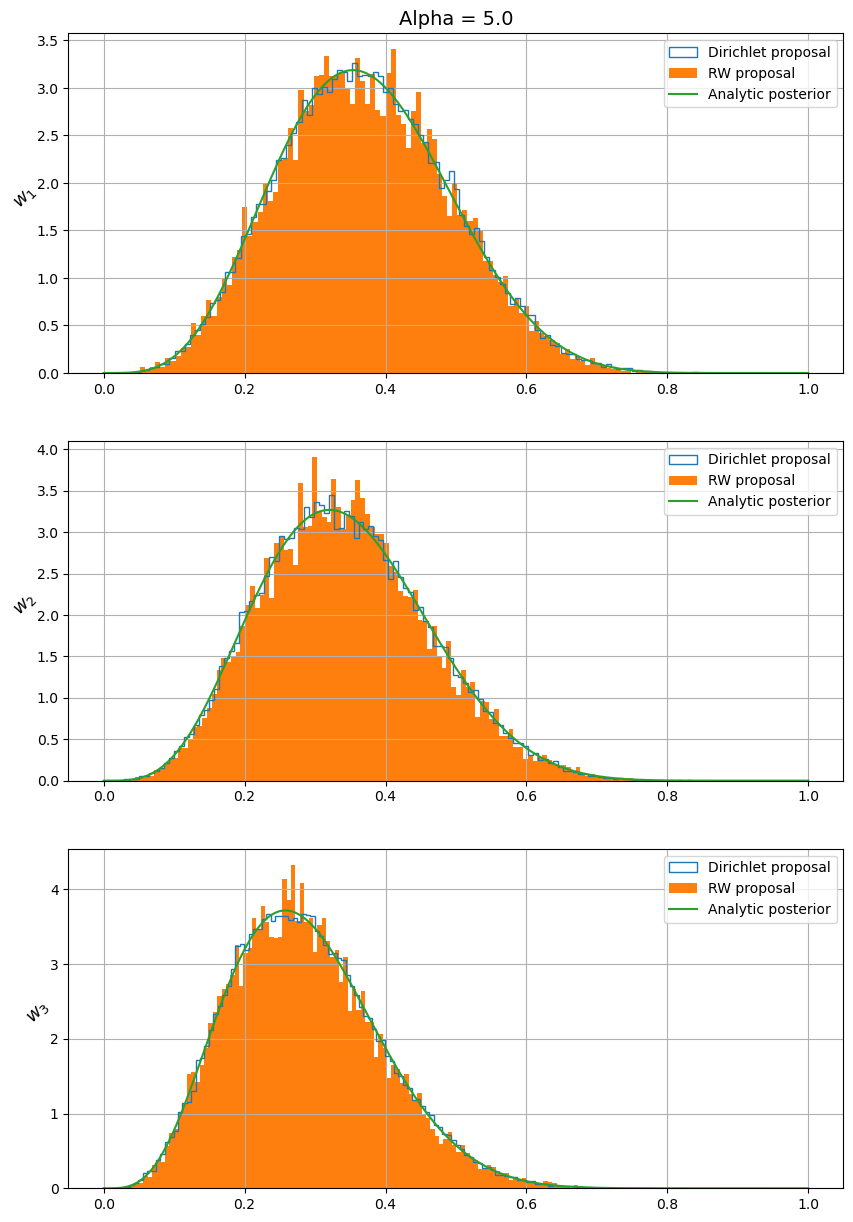

Acceptance rate 0.290323:   0%|          | 121/100000 [00:00<01:22, 1205.51it/s]

[3.85693546 0.05236014 0.91073949]


Acceptance rate 0.218875:  10%|█         | 10112/100000 [00:08<01:10, 1272.96it/s]

[9.08870117e-17 4.51866373e-15 6.48567617e-16]


Acceptance rate 0.225044:  20%|██        | 20199/100000 [00:16<01:01, 1302.94it/s]

[1.04582856e-13 3.07352594e-14 1.97888861e-14]


Acceptance rate 0.225229:  30%|███       | 30155/100000 [00:24<00:56, 1239.02it/s]

[3.76642430e-22 2.28841381e-22 1.07491259e-22]


Acceptance rate 0.223005:  40%|████      | 40119/100000 [00:32<01:02, 952.51it/s] 

[1.23678772e-22 8.06963965e-21 8.49689229e-22]


Acceptance rate 0.223369:  50%|█████     | 50170/100000 [00:43<00:49, 1013.46it/s]

[1.08306120e-16 1.52391400e-15 3.87956524e-16]


Acceptance rate 0.223720:  60%|██████    | 60077/100000 [00:53<00:46, 852.04it/s] 

[1.33761309e-27 1.47408255e-27 4.29976335e-29]


Acceptance rate 0.224079:  70%|███████   | 70135/100000 [01:04<00:31, 950.24it/s]

[5.56432594e-46 9.00779302e-45 1.27243898e-45]


Acceptance rate 0.225310:  80%|████████  | 80166/100000 [01:15<00:20, 957.81it/s]

[1.26714354e-55 3.89187817e-57 4.00660214e-56]


Acceptance rate 0.225412:  90%|█████████ | 90094/100000 [01:25<00:10, 945.91it/s] 

[3.54092184e-62 7.88832435e-62 8.50088158e-62]


100%|██████████| 100/100 [00:00<00:00, 557.75it/s]


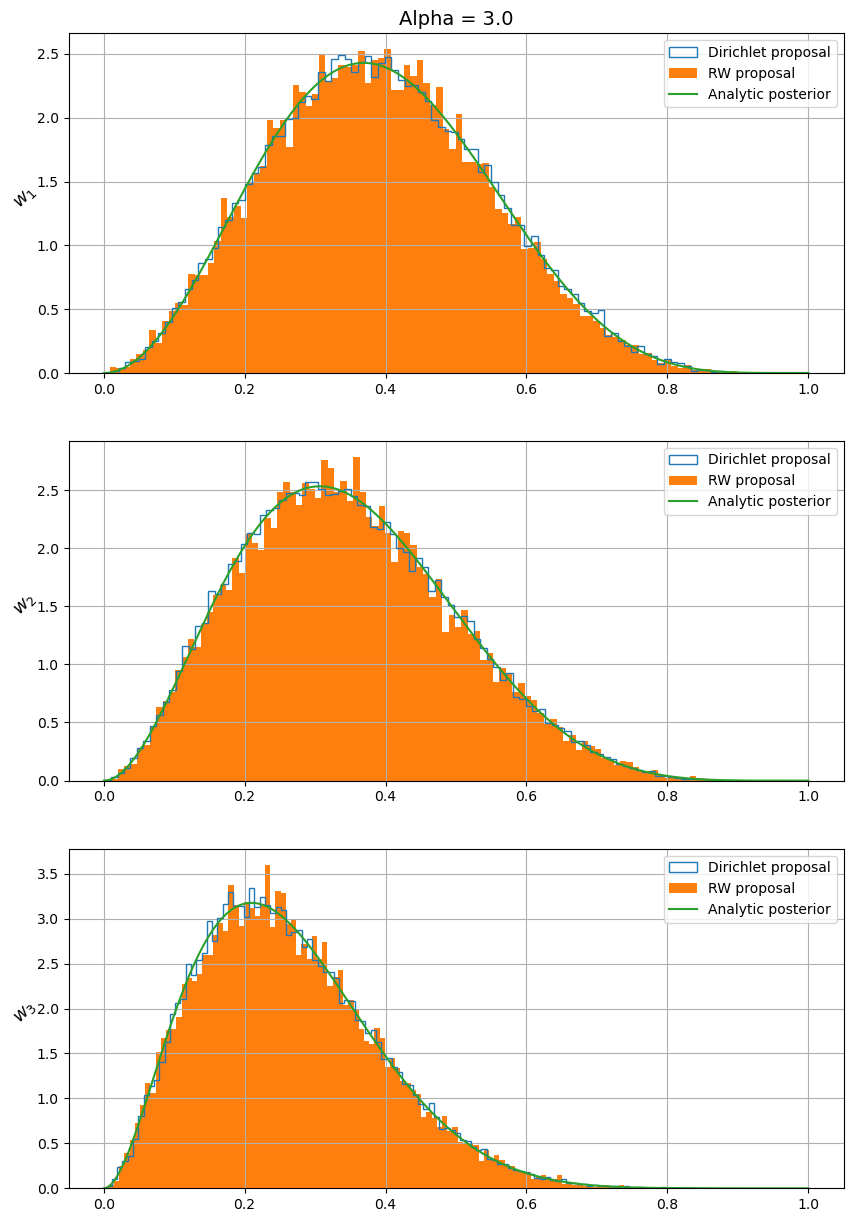

Acceptance rate 0.187879:   0%|          | 95/100000 [00:00<01:45, 949.87it/s]

[0.54673849 1.93311542 1.44752098]


Acceptance rate 0.257312:  10%|█         | 10118/100000 [00:10<01:40, 896.09it/s]

[2.65190802e-10 1.63476607e-09 3.58982027e-10]


Acceptance rate 0.258886:  20%|██        | 20116/100000 [00:21<01:07, 1190.17it/s]

[1.64085156e-22 3.86339263e-23 4.41704531e-23]


Acceptance rate 0.259097:  30%|███       | 30168/100000 [00:29<01:03, 1096.89it/s]

[1.23055167e-11 1.45406124e-11 8.18587608e-12]


Acceptance rate 0.262585:  40%|████      | 40156/100000 [00:38<00:56, 1065.51it/s]

[1.13556966e-20 1.28512266e-21 2.56201789e-21]


Acceptance rate 0.263964:  50%|█████     | 50177/100000 [00:46<00:41, 1208.46it/s]

[1.52747205e-33 4.44796589e-32 7.88791966e-33]


Acceptance rate 0.263722:  60%|██████    | 60116/100000 [00:55<00:32, 1227.61it/s]

[8.98553069e-24 4.43514650e-24 7.15310249e-25]


Acceptance rate 0.264308:  70%|███████   | 70128/100000 [01:03<00:24, 1207.18it/s]

[3.80888503e-18 7.99966661e-19 6.35986343e-19]


Acceptance rate 0.263784:  80%|████████  | 80179/100000 [01:11<00:16, 1211.82it/s]

[6.76334801e-23 8.37074636e-22 3.30029780e-22]


Acceptance rate 0.264015:  90%|█████████ | 90133/100000 [01:19<00:08, 1208.72it/s]

[5.93460766e-11 4.65251416e-12 2.99319572e-11]


100%|██████████| 100/100 [00:00<00:00, 609.71it/s]


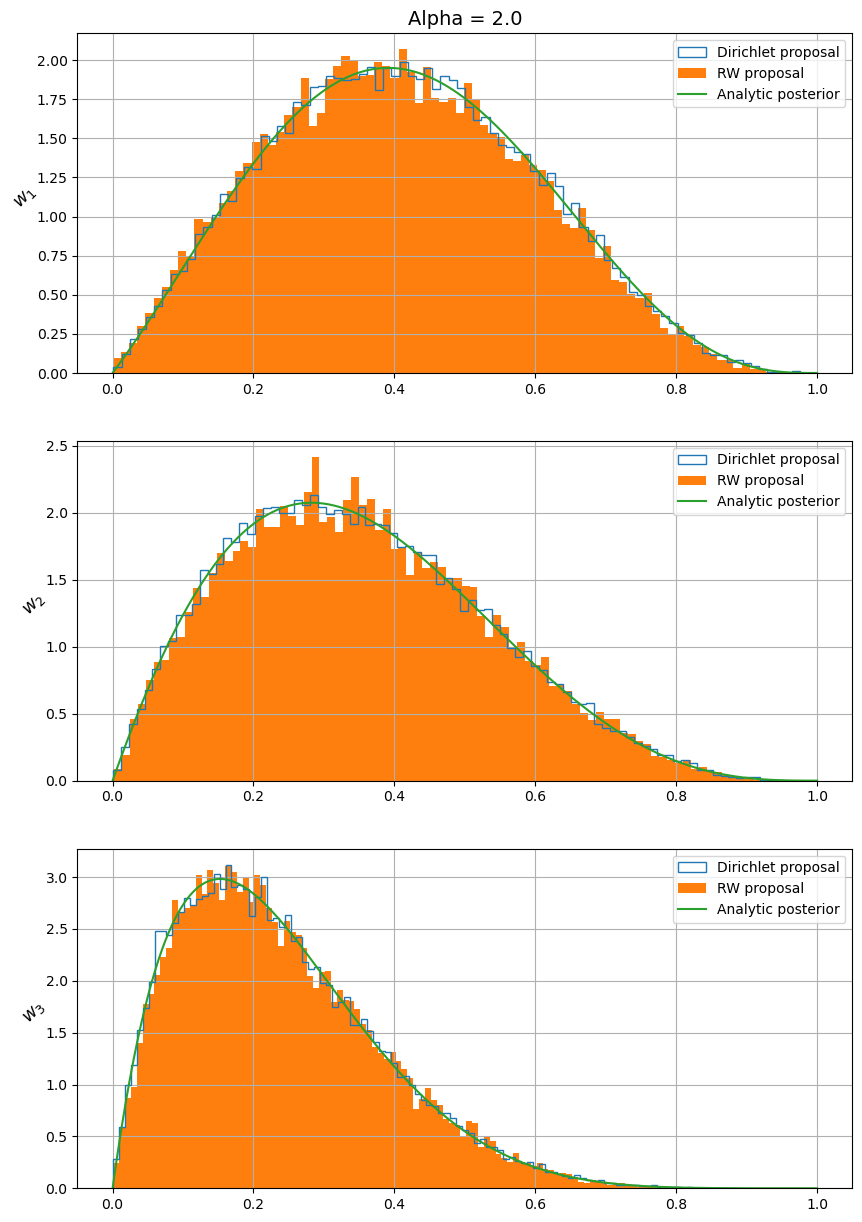

Acceptance rate 0.266376:   0%|          | 121/100000 [00:00<01:22, 1203.84it/s]

[2.26181652 1.20289532 3.74716998]


Acceptance rate 0.268200:  10%|█         | 10180/100000 [00:08<01:11, 1258.55it/s]

[8.91789770e-08 1.79499571e-07 1.88197360e-09]


Acceptance rate 0.276652:  20%|██        | 20217/100000 [00:16<01:04, 1235.55it/s]

[2.67182425e-07 1.87518559e-08 1.67867808e-08]


Acceptance rate 0.277585:  30%|███       | 30193/100000 [00:24<00:55, 1258.55it/s]

[6.68327885e-12 9.91280193e-12 4.31015858e-12]


Acceptance rate 0.279536:  40%|████      | 40201/100000 [00:32<00:48, 1239.80it/s]

[3.92875639e-17 5.74993037e-17 3.35342323e-17]


Acceptance rate 0.279211:  50%|█████     | 50188/100000 [00:40<00:40, 1235.38it/s]

[1.38140641e-09 4.77063750e-10 1.49175346e-09]


Acceptance rate 0.279354:  60%|██████    | 60139/100000 [00:48<00:32, 1223.83it/s]

[5.40005250e-02 1.52713141e-06 2.01645666e-02]


Acceptance rate 0.278017:  70%|███████   | 70221/100000 [00:56<00:24, 1221.70it/s]

[0.00038658 0.00026246 0.0001537 ]


Acceptance rate 0.277565:  80%|████████  | 80147/100000 [01:04<00:15, 1248.44it/s]

[0.00242506 0.20345102 1.09954739]


Acceptance rate 0.276926:  90%|█████████ | 90190/100000 [01:12<00:07, 1294.81it/s]

[1.77095754e-05 2.84656810e-04 3.92942551e-03]


100%|██████████| 100/100 [00:00<00:00, 600.57it/s]


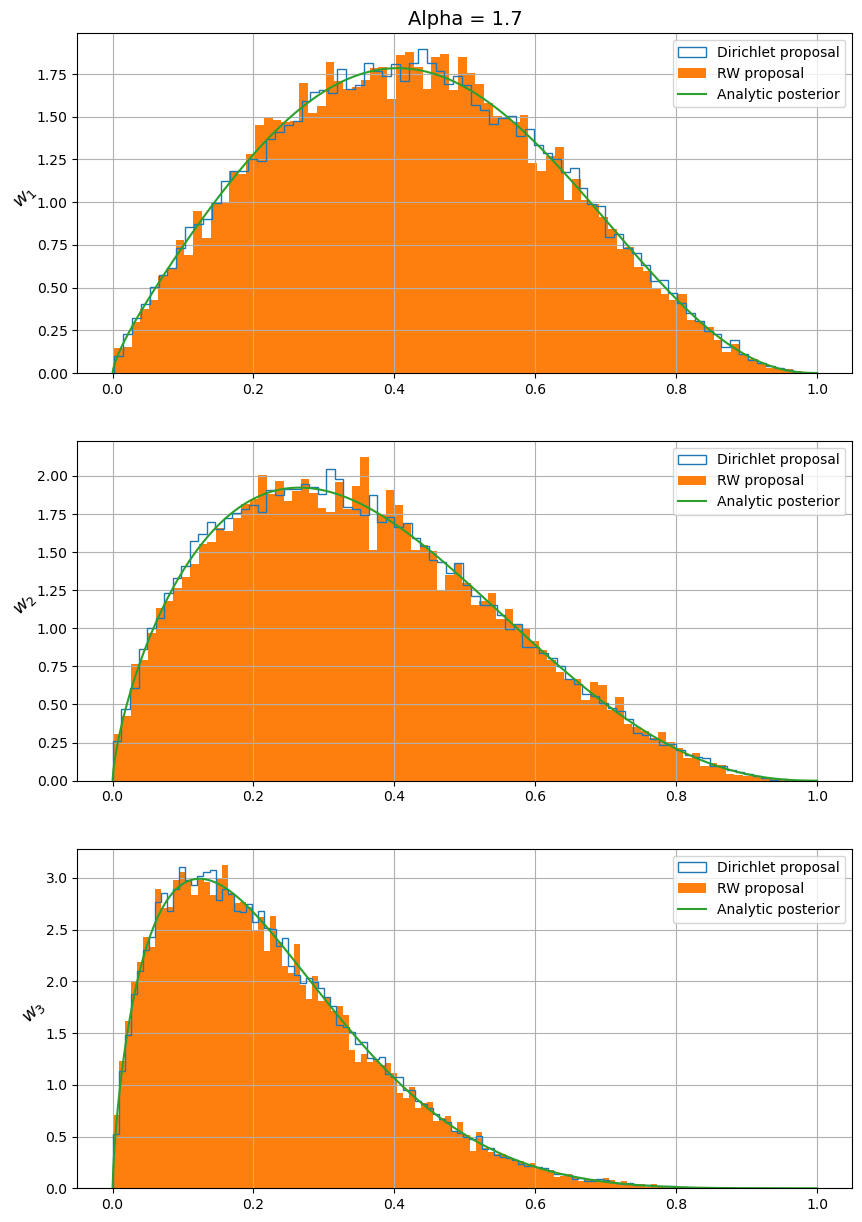

Acceptance rate 0.340249:   0%|          | 130/100000 [00:00<01:16, 1299.46it/s]

[7.46715961 3.32532849 1.3450753 ]


Acceptance rate 0.287417:  10%|█         | 10212/100000 [00:08<01:12, 1244.32it/s]

[0.26976999 0.05629539 0.01299252]


Acceptance rate 0.290841:  20%|██        | 20194/100000 [00:16<01:04, 1239.92it/s]

[1.72264843e-12 5.72176697e-13 2.37999884e-12]


Acceptance rate 0.293627:  30%|███       | 30100/100000 [00:24<00:54, 1281.40it/s]

[3.32607886e-32 4.42994673e-31 2.16783357e-31]


Acceptance rate 0.293388:  40%|████      | 40138/100000 [00:32<00:49, 1216.65it/s]

[4.93971032e-37 1.69138134e-37 3.14520847e-36]


Acceptance rate 0.293324:  50%|█████     | 50100/100000 [00:40<00:41, 1213.84it/s]

[4.65613842e-27 6.71065059e-29 2.43687587e-28]


Acceptance rate 0.292056:  60%|██████    | 60233/100000 [00:48<00:31, 1246.92it/s]

[2.37459465e-36 6.80515490e-38 1.47326418e-36]


Acceptance rate 0.291343:  70%|███████   | 70143/100000 [00:56<00:24, 1217.29it/s]

[1.07716627e-39 1.02552332e-39 1.19200254e-40]


Acceptance rate 0.291639:  80%|████████  | 80137/100000 [01:04<00:16, 1171.76it/s]

[1.19016514e-40 2.41405971e-42 1.44120598e-42]


Acceptance rate 0.293148:  90%|█████████ | 90219/100000 [01:12<00:08, 1212.66it/s]

[6.11534604e-36 6.24743898e-36 7.47741642e-36]


100%|██████████| 100/100 [00:00<00:00, 606.03it/s]


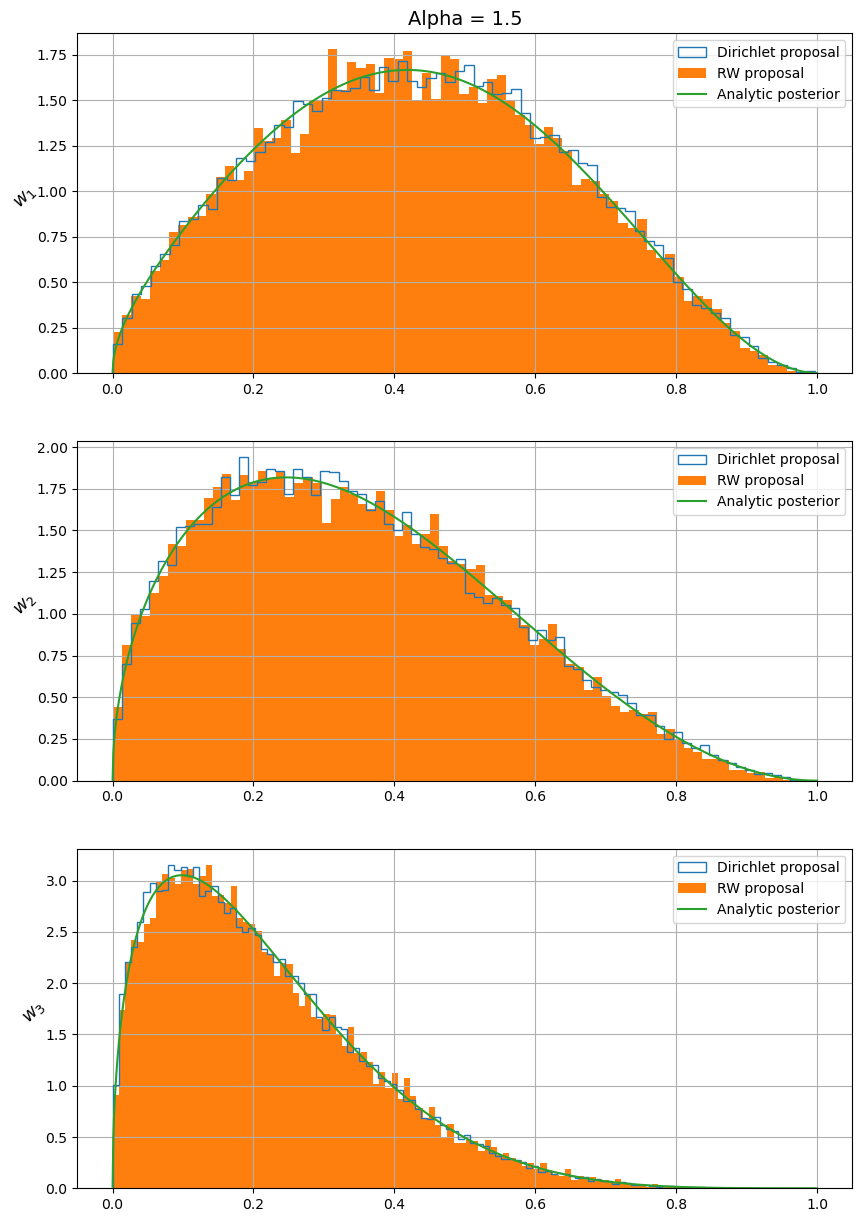

Acceptance rate 0.284444:   0%|          | 125/100000 [00:00<01:20, 1243.69it/s]

[1.25166448 2.5501483  0.00290994]


Acceptance rate 0.297332:  10%|█         | 10140/100000 [00:08<01:12, 1241.17it/s]

[1.34819823e-10 4.64372897e-10 1.83894523e-10]


Acceptance rate 0.298798:  20%|██        | 20136/100000 [00:16<01:04, 1230.28it/s]

[2.84942400e-16 6.00894327e-17 1.04655006e-18]


Acceptance rate 0.301231:  30%|███       | 30094/100000 [00:24<00:56, 1247.73it/s]

[5.98376022e-17 2.78978924e-18 1.51907488e-17]


Acceptance rate 0.300689:  40%|████      | 40111/100000 [00:32<00:47, 1254.51it/s]

[2.25418575e-26 9.72112706e-26 6.33879672e-26]


Acceptance rate 0.300344:  50%|█████     | 50179/100000 [00:40<00:40, 1244.78it/s]

[1.75273678e-19 7.03048412e-20 1.02187677e-20]


Acceptance rate 0.299482:  60%|██████    | 60210/100000 [00:48<00:32, 1232.18it/s]

[2.52227786e-43 1.83027794e-42 1.27181431e-43]


Acceptance rate 0.299428:  70%|███████   | 70186/100000 [00:56<00:23, 1273.24it/s]

[1.58181240e-43 5.44825503e-45 2.47452426e-46]


Acceptance rate 0.299374:  80%|████████  | 80206/100000 [01:04<00:15, 1256.36it/s]

[2.48223432e-46 4.36318235e-47 4.04711035e-46]


Acceptance rate 0.300207:  90%|█████████ | 90196/100000 [01:12<00:08, 1212.98it/s]

[6.25388989e-48 1.24139941e-47 5.56453069e-48]


100%|██████████| 100/100 [00:00<00:00, 600.57it/s]


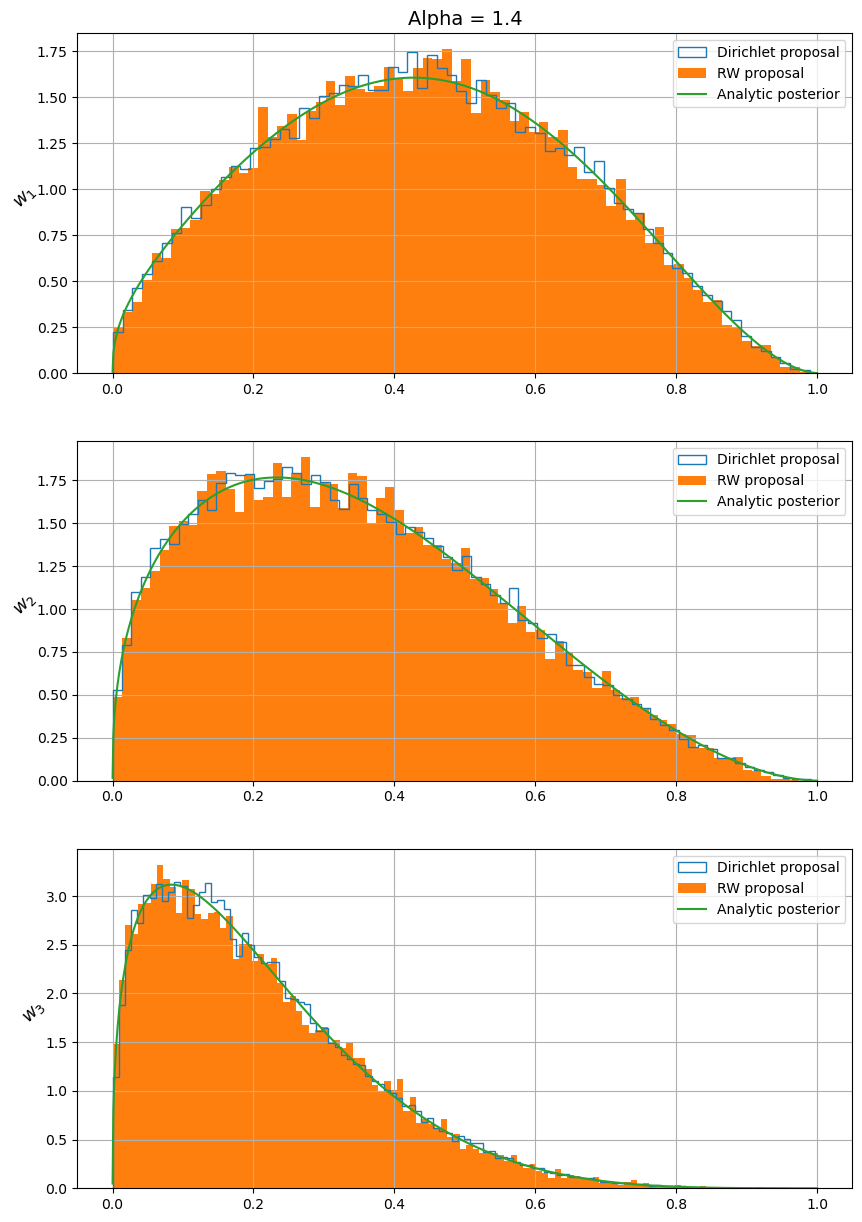

Acceptance rate 0.284444:   0%|          | 124/100000 [00:00<01:20, 1233.72it/s]

[8.92321197 0.03729884 1.81469123]


Acceptance rate 0.297416:  10%|█         | 10112/100000 [00:08<01:12, 1246.76it/s]

[0.0001464  0.00010636 0.00010509]


Acceptance rate 0.307099:  20%|██        | 20106/100000 [00:16<01:04, 1236.71it/s]

[4.30188792e-25 8.95268180e-25 4.67613727e-25]


Acceptance rate 0.303464:  30%|███       | 30169/100000 [00:24<00:58, 1201.85it/s]

[2.22054176e-18 7.25117031e-18 6.97357747e-18]


Acceptance rate 0.304835:  40%|████      | 40170/100000 [00:32<00:48, 1226.61it/s]

[4.39342868e-32 2.92778364e-31 1.22377568e-32]


Acceptance rate 0.305159:  50%|█████     | 50199/100000 [00:40<00:40, 1223.45it/s]

[6.32484223e-14 3.08519646e-15 5.37407000e-15]


Acceptance rate 0.303535:  60%|██████    | 60125/100000 [00:48<00:32, 1220.05it/s]

[4.10135147e-21 7.87260764e-21 1.96534412e-20]


Acceptance rate 0.303384:  70%|███████   | 70126/100000 [00:56<00:23, 1249.55it/s]

[8.27084600e-20 1.76366369e-20 9.42124918e-21]


Acceptance rate 0.304521:  80%|████████  | 80212/100000 [01:04<00:15, 1240.20it/s]

[2.61004636e-20 1.03919173e-19 9.10964080e-21]


Acceptance rate 0.305277:  90%|█████████ | 90135/100000 [01:13<00:07, 1249.39it/s]

[5.75333655e-38 2.06420528e-34 2.04348230e-35]


100%|██████████| 100/100 [00:00<00:00, 600.57it/s]


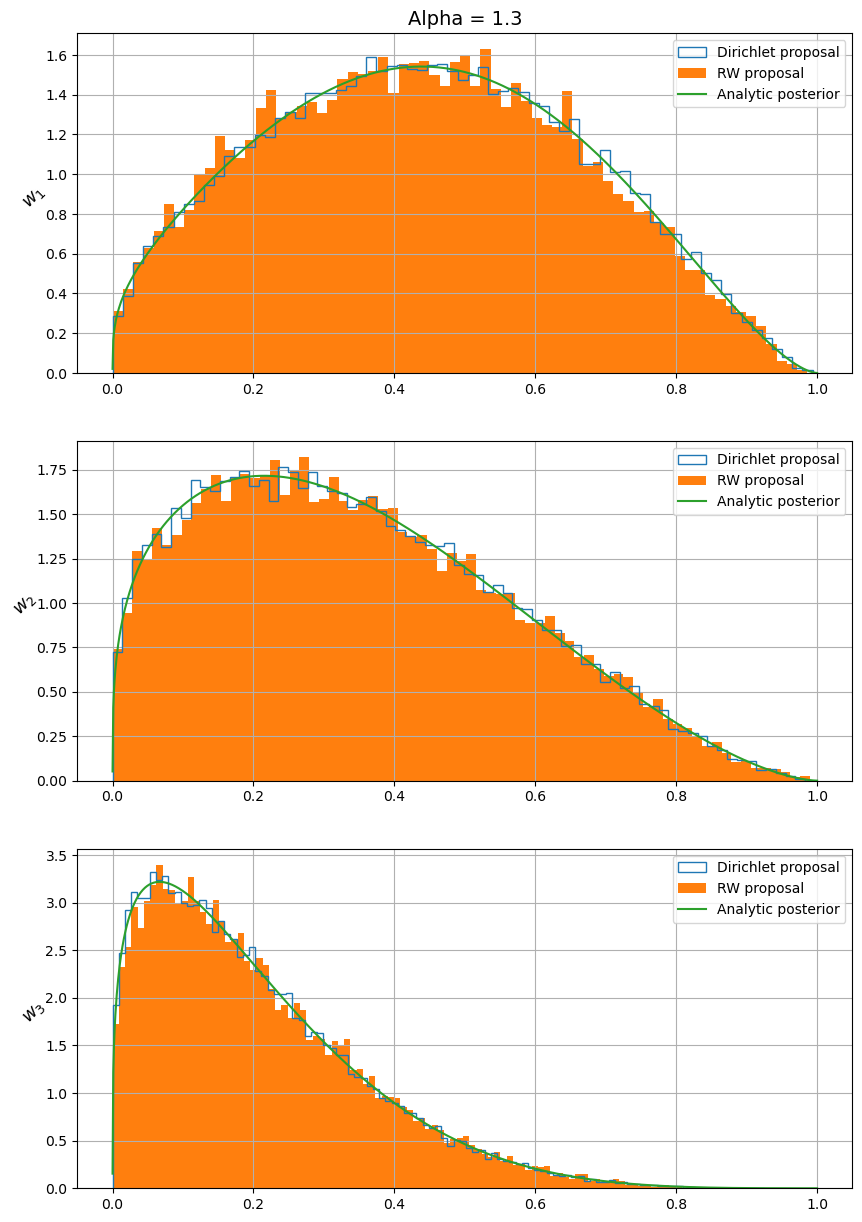

Acceptance rate 0.257143:   0%|          | 126/100000 [00:00<01:19, 1253.59it/s]

[1.46754153 1.60321933 9.4359587 ]


Acceptance rate 0.314621:  10%|█         | 10178/100000 [00:08<01:11, 1259.27it/s]

[1.70461352e-31 9.07017093e-31 4.11204217e-32]


Acceptance rate 0.308559:  20%|██        | 20154/100000 [00:16<01:03, 1264.58it/s]

[5.11950918e-20 1.29527010e-20 1.44088932e-21]


Acceptance rate 0.308232:  30%|███       | 30225/100000 [00:24<00:56, 1228.81it/s]

[8.75950530e-06 7.29099047e-08 7.89754656e-08]


Acceptance rate 0.309149:  40%|████      | 40125/100000 [00:32<00:48, 1226.93it/s]

[1.73058107e-20 3.97827869e-20 4.30279095e-21]


Acceptance rate 0.310164:  50%|█████     | 50142/100000 [00:40<00:40, 1221.25it/s]

[4.33434068e-22 2.28621157e-22 3.94535162e-22]


Acceptance rate 0.310478:  60%|██████    | 60200/100000 [00:49<00:32, 1240.94it/s]

[3.36650159e-12 5.34027400e-11 3.54628720e-12]


Acceptance rate 0.310119:  70%|███████   | 70131/100000 [00:57<00:23, 1249.00it/s]

[2.54951351e-12 8.12930310e-12 7.68378264e-12]


Acceptance rate 0.310205:  80%|████████  | 80144/100000 [01:05<00:16, 1235.00it/s]

[7.46835848e-26 2.39380045e-25 6.81763133e-27]


Acceptance rate 0.309720:  90%|█████████ | 90121/100000 [01:13<00:08, 1229.66it/s]

[2.36247574e-36 1.45900562e-35 2.73168353e-35]


100%|██████████| 100/100 [00:00<00:00, 606.03it/s]


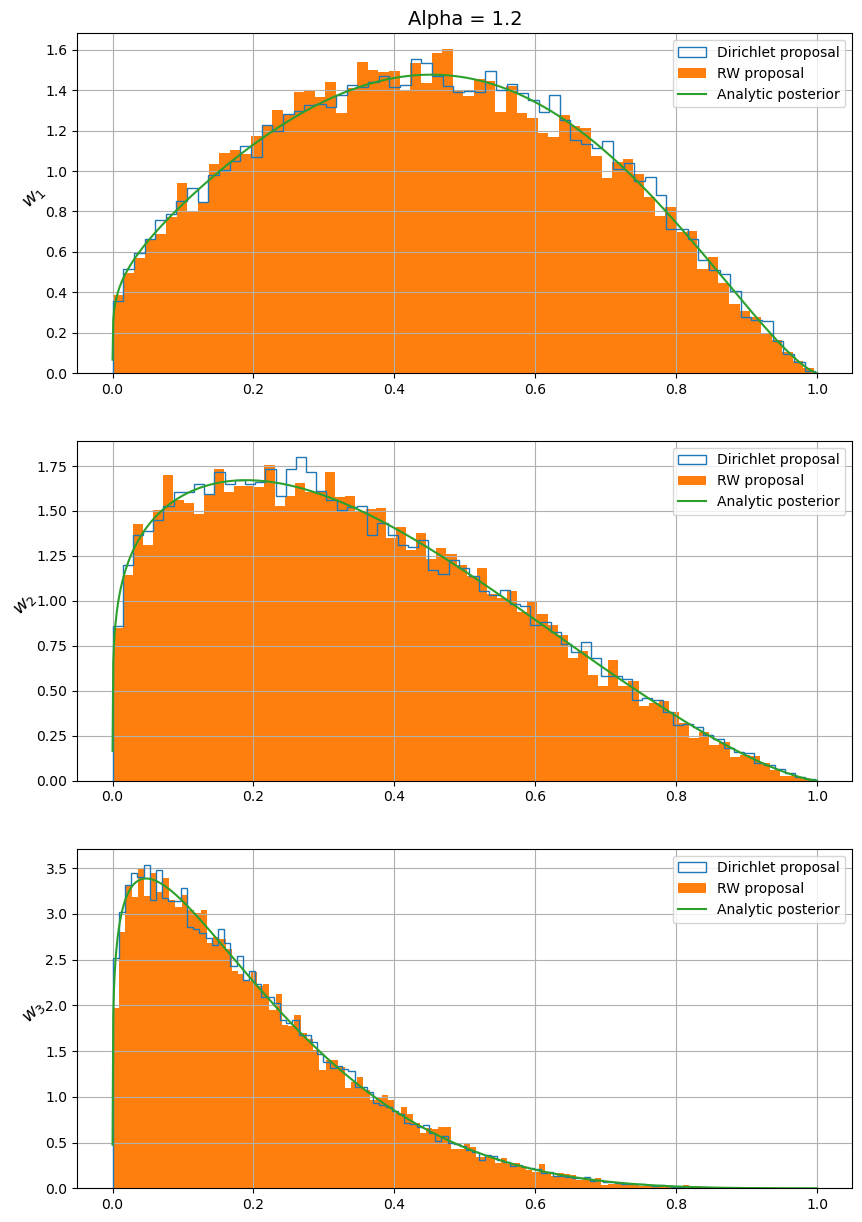

Acceptance rate 0.347639:   0%|          | 129/100000 [00:00<01:17, 1283.45it/s]

[3.58807779 1.83573099 0.40316751]


Acceptance rate 0.314132:  10%|█         | 10170/100000 [00:08<01:10, 1266.73it/s]

[3.26130458e-16 4.21441722e-16 1.28178558e-16]


Acceptance rate 0.313918:  20%|██        | 20188/100000 [00:16<01:02, 1280.33it/s]

[0.26825087 0.25874355 0.02879621]


Acceptance rate 0.314912:  30%|███       | 30147/100000 [00:24<00:53, 1298.21it/s]

[1.32971568e-19 1.26336487e-19 2.43104680e-20]


Acceptance rate 0.314772:  40%|████      | 40127/100000 [00:32<00:48, 1245.29it/s]

[1.58250336e-18 1.01368336e-16 1.46160838e-17]


Acceptance rate 0.315816:  50%|█████     | 50148/100000 [00:40<00:41, 1200.42it/s]

[1.42024766e-12 1.03799012e-11 1.01502245e-12]


Acceptance rate 0.317221:  60%|██████    | 60192/100000 [00:48<00:32, 1238.79it/s]

[3.62111467e-13 4.89163797e-14 3.07749962e-14]


Acceptance rate 0.317280:  70%|███████   | 70216/100000 [00:57<00:24, 1204.74it/s]

[4.76476093e-21 5.04374380e-20 1.30498371e-20]


Acceptance rate 0.318310:  80%|████████  | 80173/100000 [01:05<00:16, 1200.09it/s]

[5.67226866e-12 6.18053842e-13 3.05365231e-14]


Acceptance rate 0.318991:  90%|█████████ | 90173/100000 [01:14<00:08, 1197.13it/s]

[8.70373337e-16 2.13202957e-15 3.92555069e-18]


100%|██████████| 100/100 [00:00<00:00, 568.14it/s]


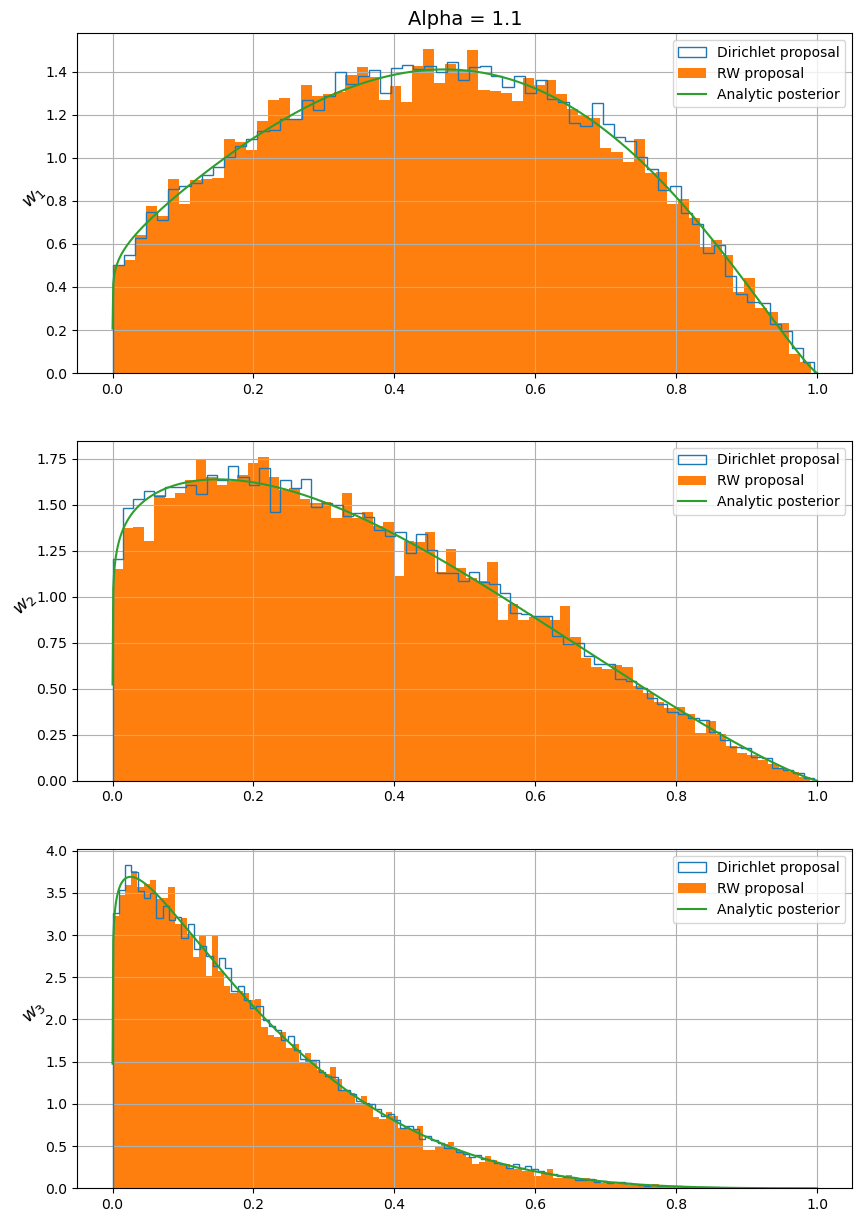

Acceptance rate 0.345000:   0%|          | 109/100000 [00:00<01:32, 1084.47it/s]

[6.63856808 2.83547332 1.63013375]


Acceptance rate 0.327978:  10%|█         | 10127/100000 [00:08<01:18, 1151.03it/s]

[6.55189112e-03 9.06439753e-06 1.19230907e-04]


Acceptance rate 0.325190:  20%|██        | 20140/100000 [00:16<01:06, 1194.24it/s]

[4.69898187e-08 3.87702500e-08 2.12617261e-08]


Acceptance rate 0.327766:  30%|███       | 30120/100000 [00:25<01:09, 1000.04it/s]

[2.24181916e-13 2.48070224e-14 7.58691303e-18]


Acceptance rate 0.326279:  40%|████      | 40150/100000 [00:35<00:50, 1194.37it/s]

[1.73776405e-41 9.91825576e-43 9.12772701e-43]


Acceptance rate 0.325475:  50%|█████     | 50148/100000 [00:43<00:41, 1200.02it/s]

[1.58635159e-56 1.55196247e-56 7.75119976e-58]


Acceptance rate 0.324750:  60%|██████    | 60186/100000 [00:52<00:34, 1159.48it/s]

[1.64222085e-53 1.51617792e-54 3.30233440e-53]


Acceptance rate 0.324847:  70%|███████   | 70192/100000 [01:00<00:24, 1236.19it/s]

[7.31045338e-68 1.07907466e-68 6.34756265e-69]


Acceptance rate 0.324981:  80%|████████  | 80133/100000 [01:08<00:16, 1229.59it/s]

[4.71716869e-61 2.78088677e-63 2.83252094e-61]


Acceptance rate 0.325115:  90%|█████████ | 90150/100000 [01:16<00:08, 1216.95it/s]

[6.84345874e-60 3.86314764e-61 6.68233898e-60]


100%|██████████| 100/100 [00:00<00:00, 615.35it/s]


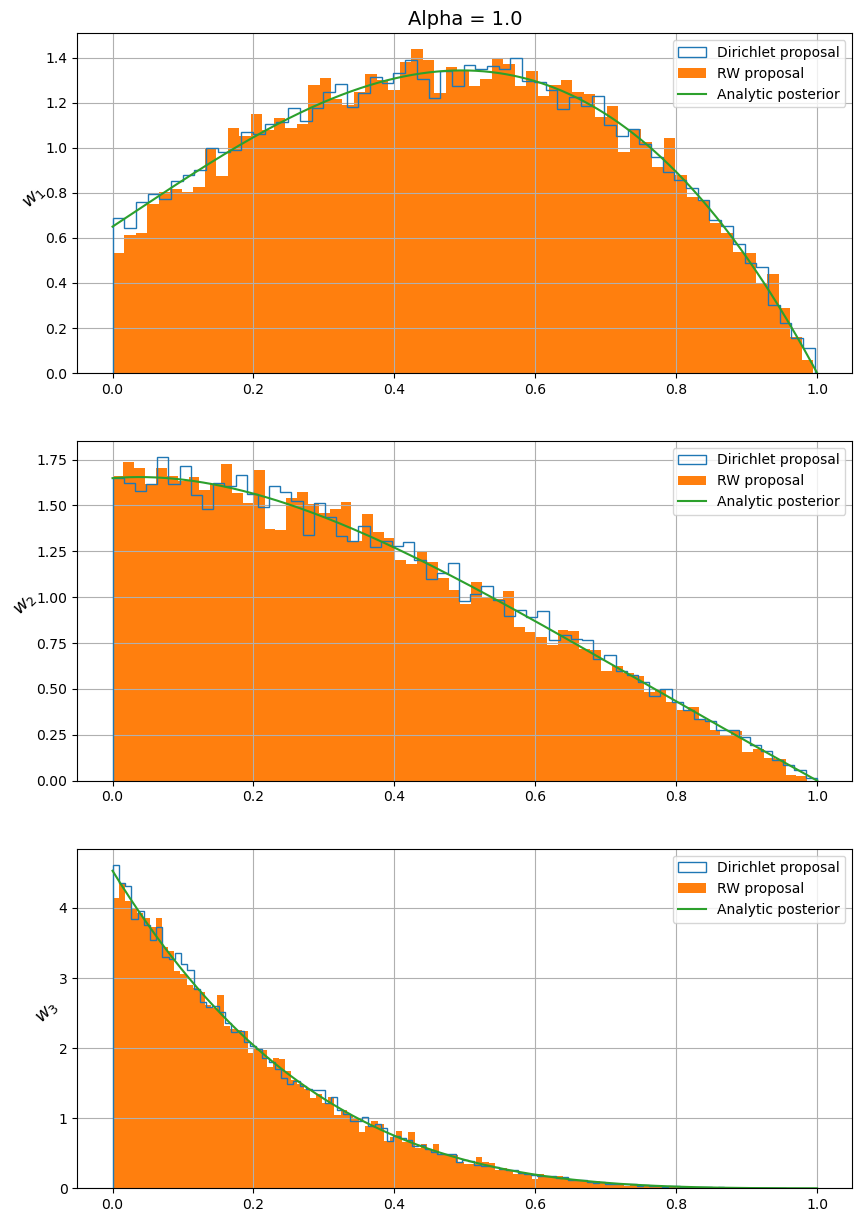

Acceptance rate 0.356522:   0%|          | 126/100000 [00:00<01:19, 1253.63it/s]

[8.54788872 0.23342395 1.18041464]


Acceptance rate 0.334540:  10%|█         | 10193/100000 [00:08<01:13, 1224.93it/s]

[3.03583184e-09 2.99825507e-12 2.52786608e-10]


Acceptance rate 0.334718:  20%|██        | 20162/100000 [00:16<01:04, 1230.33it/s]

[7.96222759e-12 9.32974406e-13 2.12658580e-13]


Acceptance rate 0.335814:  30%|███       | 30211/100000 [00:24<00:56, 1241.46it/s]

[5.24625322e-10 1.70513159e-10 1.01712248e-10]


Acceptance rate 0.335098:  40%|████      | 40200/100000 [00:32<00:47, 1271.26it/s]

[4.06373984e-33 7.87911246e-33 2.41844870e-34]


Acceptance rate 0.335676:  50%|█████     | 50173/100000 [00:40<00:39, 1258.74it/s]

[1.42738992e-23 6.04479815e-25 2.34559436e-26]


Acceptance rate 0.336953:  60%|██████    | 60192/100000 [00:48<00:31, 1259.77it/s]

[4.21694548e-06 2.58153589e-08 2.14381620e-07]


Acceptance rate 0.334862:  70%|███████   | 70218/100000 [00:56<00:23, 1261.12it/s]

[0.03467175 0.03820255 0.00652419]


Acceptance rate 0.334214:  80%|████████  | 80115/100000 [01:04<00:15, 1247.42it/s]

[1.17402629e-10 5.52329512e-12 4.14243100e-12]


Acceptance rate 0.334830:  90%|█████████ | 90208/100000 [01:12<00:07, 1237.74it/s]

[1.82926243e-01 4.47664092e-05 6.25396083e-02]


100%|██████████| 100/100 [00:00<00:00, 606.02it/s]


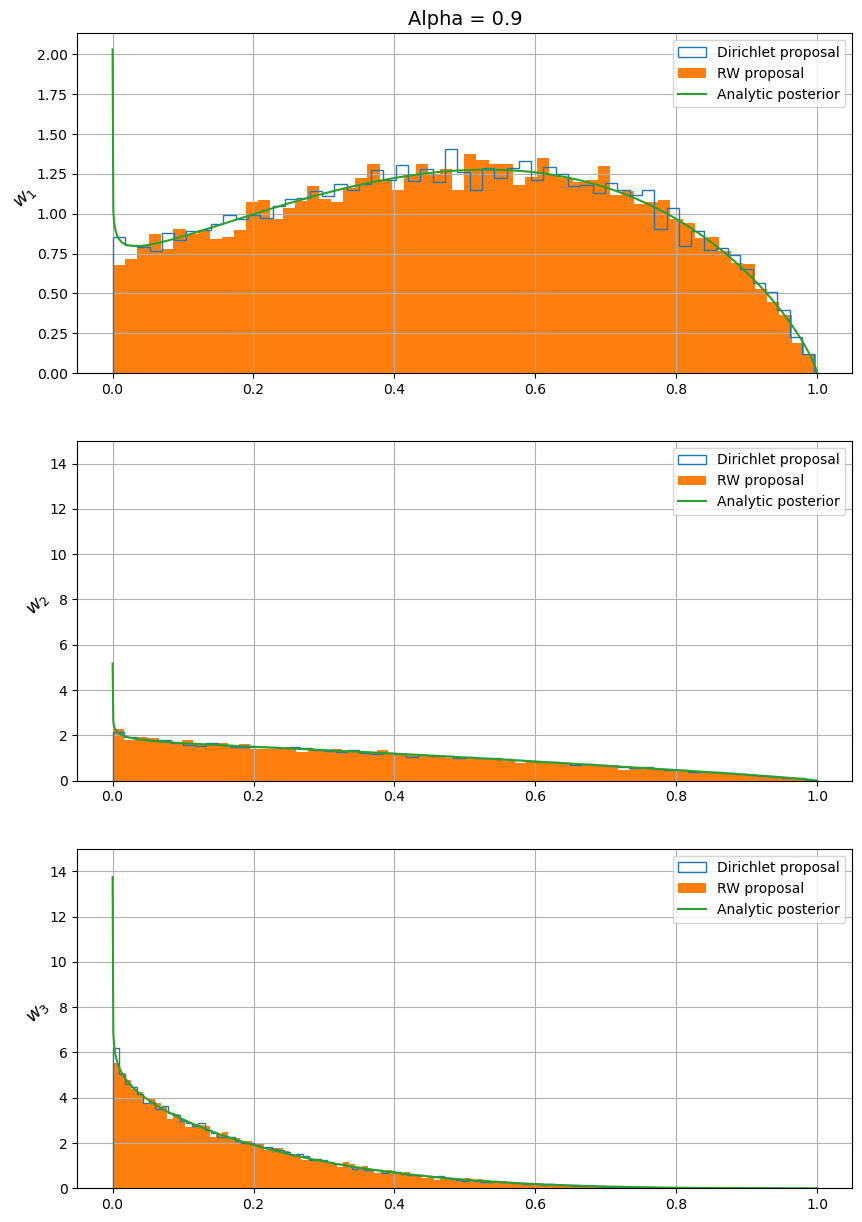

Acceptance rate 0.330233:   0%|          | 122/100000 [00:00<01:22, 1213.83it/s]

[10.60384036  3.6382218   0.57508184]


Acceptance rate 0.343196:  10%|█         | 10190/100000 [00:08<01:15, 1191.69it/s]

[9.17553005e-08 4.55489393e-09 1.20498422e-08]


Acceptance rate 0.342470:  20%|██        | 20099/100000 [00:17<01:09, 1150.98it/s]

[4.64265956e-14 2.05068721e-13 1.20212924e-14]


Acceptance rate 0.338912:  30%|███       | 30110/100000 [00:26<01:16, 916.44it/s] 

[3.27894359e-06 6.36912452e-05 1.11689225e-06]


Acceptance rate 0.337460:  40%|████      | 40161/100000 [00:36<00:49, 1209.58it/s]

[4.37443592e-06 2.41485253e-06 2.89005242e-07]


Acceptance rate 0.339931:  50%|█████     | 50135/100000 [00:44<00:42, 1164.28it/s]

[1.00732498e-06 3.00496339e-07 7.68353191e-08]


Acceptance rate 0.339138:  60%|██████    | 60132/100000 [00:52<00:31, 1260.35it/s]

[1.01412278e-05 1.41484529e-04 7.36075524e-06]


Acceptance rate 0.340649:  70%|███████   | 70127/100000 [01:00<00:24, 1238.27it/s]

[3.08060353e-11 9.83773354e-10 4.26216896e-10]


Acceptance rate 0.339695:  80%|████████  | 80169/100000 [01:08<00:16, 1189.19it/s]

[7.23891377e-15 5.73778348e-15 2.96096816e-14]


Acceptance rate 0.339722:  90%|█████████ | 90105/100000 [01:17<00:08, 1219.56it/s]

[1.62800410e-15 2.01693047e-16 6.85761024e-15]


100%|██████████| 100/100 [00:00<00:00, 600.57it/s]


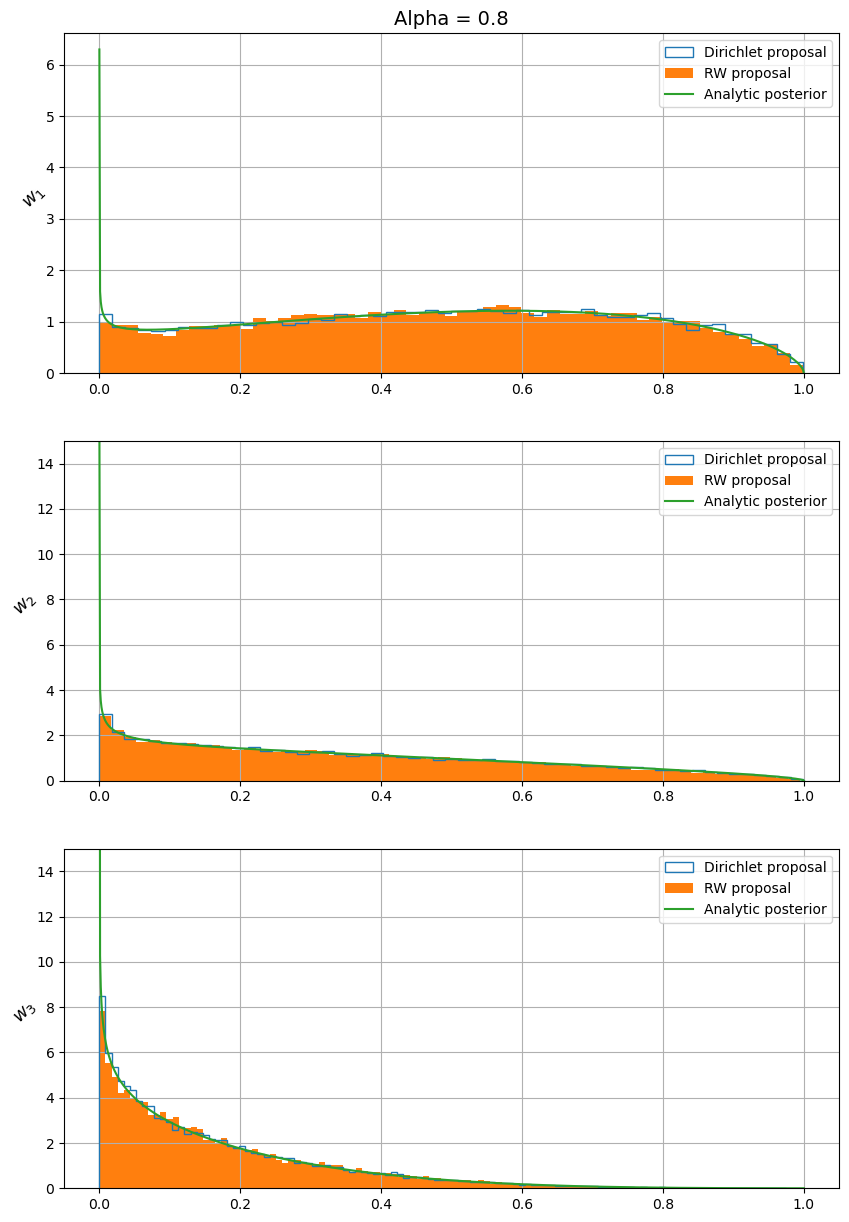

Acceptance rate 0.333333:   0%|          | 126/100000 [00:00<01:19, 1253.61it/s]

[4.91365192 2.33965189 1.8045928 ]


Acceptance rate 0.352424:  10%|█         | 10181/100000 [00:08<01:11, 1252.85it/s]

[2.50097328e-15 4.04873857e-13 7.86945558e-15]


Acceptance rate 0.351322:  20%|██        | 20150/100000 [00:16<01:05, 1219.29it/s]

[4.10125614e-11 2.53488939e-13 8.00393683e-13]


Acceptance rate 0.353237:  30%|███       | 30218/100000 [00:24<00:57, 1215.52it/s]

[7.65440774e-16 9.55769205e-21 4.74018396e-20]


Acceptance rate 0.353326:  40%|████      | 40140/100000 [00:32<00:48, 1223.47it/s]

[0.07491206 0.19407281 0.16145387]


Acceptance rate 0.352374:  50%|█████     | 50206/100000 [00:41<00:40, 1230.00it/s]

[6.30316484e-17 6.09982753e-17 8.44934907e-18]


Acceptance rate 0.351559:  60%|██████    | 60121/100000 [00:49<00:31, 1249.78it/s]

[4.98006550e-15 4.50696820e-15 1.23081035e-15]


Acceptance rate 0.351586:  70%|███████   | 70147/100000 [00:57<00:23, 1248.35it/s]

[1.49118865e-13 4.44748321e-14 7.83891043e-14]


Acceptance rate 0.351621:  80%|████████  | 80101/100000 [01:05<00:15, 1248.07it/s]

[2.85968179e-36 2.20752517e-36 1.65391018e-38]


Acceptance rate 0.351583:  90%|█████████ | 90209/100000 [01:13<00:07, 1237.79it/s]

[1.48870301e-39 6.51239261e-40 8.24703595e-40]


100%|██████████| 100/100 [00:00<00:00, 598.77it/s]


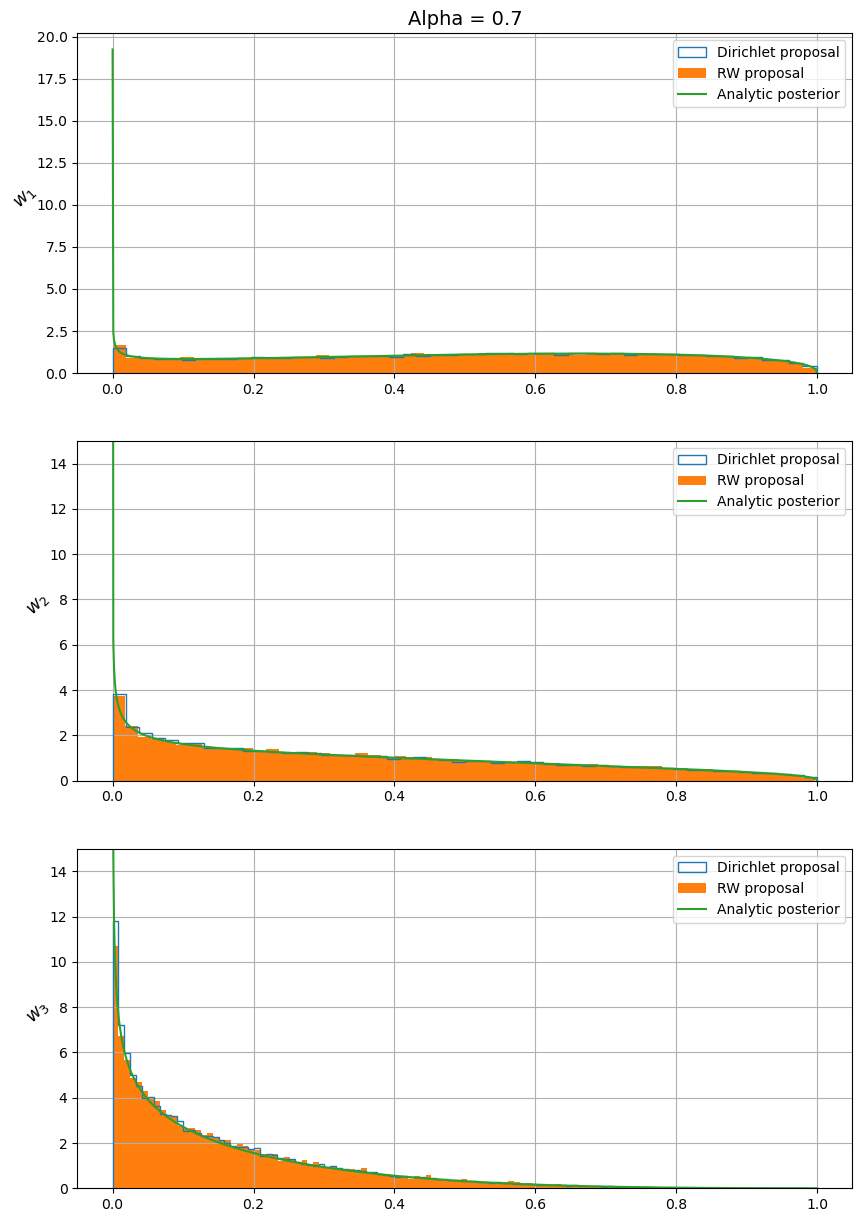

Acceptance rate 0.342593:   0%|          | 119/100000 [00:00<01:24, 1183.98it/s]

[0.48711271 5.73806678 0.67132   ]


Acceptance rate 0.370138:  10%|█         | 10097/100000 [00:08<01:22, 1089.51it/s]

[2.86925308e-07 4.32533890e-08 7.42080152e-09]


Acceptance rate 0.366581:  20%|██        | 20195/100000 [00:17<01:07, 1186.98it/s]

[5.66891675e-14 7.34130541e-15 1.23401763e-13]


Acceptance rate 0.362752:  30%|███       | 30206/100000 [00:25<00:58, 1183.99it/s]

[9.85796898e-06 3.56964047e-04 8.79052832e-05]


Acceptance rate 0.363184:  40%|████      | 40148/100000 [00:34<00:49, 1198.53it/s]

[5.68964151e-18 1.56721321e-17 8.63756290e-17]


Acceptance rate 0.362766:  50%|█████     | 50175/100000 [00:42<00:41, 1201.82it/s]

[6.91121819e-10 5.48461131e-11 3.21718920e-11]


Acceptance rate 0.363051:  60%|██████    | 60098/100000 [00:50<00:33, 1196.21it/s]

[1.44186694e-11 5.20074193e-10 6.96880827e-12]


Acceptance rate 0.363204:  70%|███████   | 70138/100000 [00:59<00:24, 1205.32it/s]

[2.14136510e-11 4.24533411e-10 1.30146503e-13]


Acceptance rate 0.363409:  80%|████████  | 80168/100000 [01:07<00:16, 1209.36it/s]

[5.14746126e-13 8.34626173e-17 3.01261087e-16]


Acceptance rate 0.362837:  89%|████████▉ | 89148/100000 [01:15<00:10, 1074.27it/s]

In [6]:

for a in [5,3,2,1.7,1.5,1.4,1.3,1.2,1.1,1.0,0.9,0.8, 0.7, 0.6, 0.5]:
    alpha = np.ones(n_pars)*a
    alpha_prop = alpha
    samples = sampling(n, xt, alpha, alpha_prop)
    eps = 1
    each = int(1e4)
    samples2 = sampling2(n, xt, alpha, eps, each)

    anal_x = []
    anal = []
    for i in range(n_pars):
        x,y = an_post(i, 100, xt, alpha)
        anal_x.append(x)
        anal.append(y)

    fig, axs = plt.subplots( n_pars, figsize = [10,15] )
    w = samples
    w2 = samples2
    x = np.arange(0, len(w[0]))
    for i in range(n_pars):
        axs[i].hist(np.transpose(w)[i], bins = 'auto', histtype='step', density = True, label = 'Dirichlet proposal')
        axs[i].hist(np.transpose(w2)[i], bins = 'auto', density = True, label = 'RW proposal')
        axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
        #axs[i].plot(anal_x[i], anal[i], label = 'Numerical posterior')
        if i == 0 : 
            xx = np.linspace(1e-6,1,1000)
            axs[i].plot(xx, w1_post(xx, alpha, xt), label = 'Analytic posterior')
        if i == 1 : 
            xx = np.linspace(1e-6,1,1000)
            axs[i].plot(xx, w2_post(xx, alpha, xt), label = 'Analytic posterior')
        if i == 2 : 
            xx = np.linspace(1e-6,1,1000)
            axs[i].plot(xx, w3_post(xx, alpha, xt), label = 'Analytic posterior')
        axs[i].grid()
        axs[i].legend()
        if a < 1:
            if i > 0 : axs[i].set_ylim([0,15])
    axs[0].set_title(f'Alpha = {alpha[0]}', size = 14)
    plt.savefig('Alpha'+str(alpha[0])+'_third_sameA.png')
    plt.show()
    plt.close()

